# Smart Restaurant Multi-Agent System (SRMAS)
**Author:** manut03  
**Project:** Agents Intensive - Capstone Project (Concierge / Enterprise hybrid)  
**Notebook version:** Initial Multi-Agent System Build

**Short description:** SRMAS is an offline-capable, multi-agent assistant for small restaurants. It demonstrates multi-agent coordination (billing agent, inventory agent, analytics agent), session & memory management, and simple tool integration (inventory adjustments, bill generation, reports).

---

## Table of contents
1. Setup & dependencies
2. Data (synthetic menu & inventory)
3. Agent definitions & runner (simulated agent flows)
4. Place orders / Billing demo
5. Inventory updates & memory bank
6. Analytics and reporting (top items, daily summary)
7. Conclusions & next steps


**Setup & dependencies (header + install)**

In [1]:
!pip install -q pandas numpy matplotlib rich
print("Cell 1: deps OK")

Cell 1: deps OK


**Synthetic menu & inventory creation**

In [8]:
# Cell 2 - Create synthetic menu & inventory (saved under ./data)
# Imports and synthetic dataset files
import os, uuid, asyncio, datetime, json
from dataclasses import dataclass, field
from typing import Dict, List, Any
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rich import print as rprint
from pprint import pprint

# Create a reproducible synthetic menu + inventory CSVs
menu = [
    {"item_id":"M001","name":"Idly","category":"Breakfast","price":30,"unit":"plate"},
    {"item_id":"M002","name":"Dosa","category":"Breakfast","price":50,"unit":"plate"},
    {"item_id":"M003","name":"Fried Rice","category":"Main","price":120,"unit":"plate"},
    {"item_id":"M004","name":"Paneer Curry","category":"Main","price":180,"unit":"plate"},
    {"item_id":"M005","name":"Coke","category":"Beverage","price":40,"unit":"bottle"},
    {"item_id":"M006","name":"Coffee","category":"Beverage","price":35,"unit":"cup"}
]

inventory = [
    {"item_id":"I001","name":"Rice (kg)","qty":20,"unit":"kg"},
    {"item_id":"I002","name":"Paneer (kg)","qty":5,"unit":"kg"},
    {"item_id":"I003","name":"Vegetables (kg)","qty":30,"unit":"kg"},
    {"item_id":"I004","name":"Coke Bottles","qty":50,"unit":"pcs"},
    {"item_id":"I005","name":"Coffee Powder (kg)","qty":2,"unit":"kg"},
    {"item_id":"I006","name":"Dosa Batter (lit)","qty":10,"unit":"l"}
]

# Save CSVs
os.makedirs("data", exist_ok=True)
pd.DataFrame(menu).to_csv("data/menu.csv", index=False)
pd.DataFrame(inventory).to_csv("data/inventory.csv", index=False)
# sales empty initially
pd.DataFrame(columns=["sale_id","timestamp","items","total"]).to_csv("data/sales.csv", index=False)

rprint("[green]Cell 2: synthetic menu & inventory created under ./data[/green]")
pd.DataFrame(menu)


Cell 2: synthetic menu & inventory created under ./data

,item_id,name,category,price,unit
0,M001,Idly,Breakfast,30,plate
1,M002,Dosa,Breakfast,50,plate
2,M003,Fried Rice,Main,120,plate
3,M004,Paneer Curry,Main,180,plate
4,M005,Coke,Beverage,40,bottle
5,M006,Coffee,Beverage,35,cup


**Agent skeletons & session service**

In [3]:
# Agent classes, session + memory
from collections import defaultdict
import asyncio
import logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

# Simple in-memory session service (satisfies "Sessions & Memory")
class InMemorySessionService:
    def __init__(self):
        self.sessions = {}
    async def create_session(self, user_id, session_id, app_name):
        self.sessions[session_id] = {"user_id":user_id,"app_name":app_name,"state":{}, "created":datetime.datetime.utcnow().isoformat()}
    async def get_session(self, session_id):
        return self.sessions.get(session_id)
    async def update_state(self, session_id, key, value):
        self.sessions[session_id]["state"][key]=value
    async def get_state(self, session_id, key, default=None):
        return self.sessions[session_id]["state"].get(key, default)

# Memory Bank (long term memory simulation)
class MemoryBank:
    def __init__(self):
        self.storage = defaultdict(list)
    def remember(self, user_id, note):
        self.storage[user_id].append({"note":note,"ts":datetime.datetime.utcnow().isoformat()})
    def recall(self, user_id, limit=10):
        return list(reversed(self.storage[user_id]))[:limit]

# Base Agent
class AgentBase:
    def __init__(self, name, session_service:InMemorySessionService, memory:MemoryBank):
        self.name = name
        self.session_service = session_service
        self.memory = memory
    async def handle(self, session_id, payload):
        raise NotImplementedError


**Runner & memory bank setup**

In [10]:
# Implement concrete agents & coordinator
import csv, math

# Load data helpers (simple "tools")
MENU_DF = pd.read_csv("data/menu.csv")
INV_DF = pd.read_csv("data/inventory.csv")
SALES_PATH = "data/sales.csv"

def get_menu_item_by_name(name):
    row = MENU_DF[MENU_DF['name'].str.lower()==name.lower()]
    if len(row)==0:
        return None
    return row.iloc[0].to_dict()

def persist_sale(sale):
    df = pd.read_csv(SALES_PATH)
    df = pd.concat([df, pd.DataFrame([sale])], ignore_index=True)
    df.to_csv(SALES_PATH, index=False)

# Agents
class MenuAgent(AgentBase):
    async def handle(self, session_id, payload):
        # payload: {"action":"list" or "info", ...}
        if payload.get("action")=="list":
            return {"menu": MENU_DF.to_dict(orient="records")}
        elif payload.get("action")=="info":
            item = get_menu_item_by_name(payload["item"])
            return {"item": item}
        return {"error":"unknown action"}

class InventoryAgent(AgentBase):
    async def handle(self, session_id, payload):
        # payload: {"action":"check" / "update", ...}
        if payload.get("action")=="check":
            df = pd.read_csv("data/inventory.csv")
            return {"inventory": df.to_dict(orient="records")}
        elif payload.get("action")=="update":
            # update qty of named inventory element (simulate raw-material reduction)
            df = pd.read_csv("data/inventory.csv")
            idx = df[df['name']==payload['name']].index
            if len(idx)==0:
                return {"error":"item not found"}
            i = idx[0]
            df.at[i,'qty'] = max(0, df.at[i,'qty'] - payload.get("delta",0))
            df["qty"] = df["qty"].round(2)
            df.to_csv("data/inventory.csv", index=False)
            return {"ok":True, "inventory": df.to_dict(orient="records")}
        return {"error":"unknown action"}

class BillingAgent(AgentBase):
    async def handle(self, session_id, payload):
        # payload: {"action":"create_bill","order":[{"name":..., "qty":int}, ...]}
        if payload.get("action")=="create_bill":
            order = payload.get("order", [])
            total = 0
            items_out = []
            for it in order:
                menu_item = get_menu_item_by_name(it["name"])
                if not menu_item:
                    items_out.append({"name":it["name"], "error":"not on menu"})
                    continue
                price = float(menu_item["price"])
                qty = int(it.get("qty",1))
                line_total = price * qty
                total += line_total
                items_out.append({"name":menu_item["name"], "qty":qty, "price":price, "line_total":line_total})
            sale = {"sale_id": str(uuid.uuid4()), "timestamp": datetime.datetime.utcnow().isoformat(), "items": json.dumps(items_out), "total": total}
            persist_sale(sale)
            # Remember for memory bank
            self.memory.remember("demo", f"placed order {sale['sale_id']} tot={total}")
            return {"bill": items_out, "total": total, "sale_id": sale['sale_id']}
        return {"error":"unknown action"}

class ReportAgent(AgentBase):
    async def handle(self, session_id, payload):
        # payload: {"action":"daily_summary" / "top_items"}
        df = pd.read_csv(SALES_PATH)
        if len(df)==0:
            return {"msg":"no sales yet"}
        if payload.get("action")=="daily_summary":
            # sum totals by date
            df['date'] = pd.to_datetime(df['timestamp']).dt.date
            summary = df.groupby('date')['total'].agg(['sum','count']).reset_index().to_dict(orient="records")
            return {"daily_summary": summary}
        if payload.get("action")=="top_items":
            # aggregate items
            all_items = []
            for r in df['items']:
                recs = json.loads(r)
                for x in recs:
                    all_items.append((x['name'], x.get('qty',1)))
            if not all_items:
                return {"top_items": []}
            s = {}
            for name, q in all_items:
                s[name] = s.get(name,0) + q
            top = sorted(s.items(), key=lambda x: x[1], reverse=True)
            return {"top_items": top}
        return {"error":"unknown action"}

# Coordinator/Runner (sequential + parallel behaviors)
class Coordinator:
    def __init__(self, session_service, memory):
        self.session_service = session_service
        self.memory = memory
        # instantiate agents
        self.menu_agent = MenuAgent("menu", session_service, memory)
        self.inventory_agent = InventoryAgent("inventory", session_service, memory)
        self.billing_agent = BillingAgent("billing", session_service, memory)
        self.report_agent = ReportAgent("report", session_service, memory)

    async def place_order(self, session_id, order):
        # sequential flow: billing -> inventory update -> reportable event
        logging.info("Coordinator: creating bill")
        bill_resp = await self.billing_agent.handle(session_id, {"action":"create_bill", "order":order})
        if "error" in bill_resp:
            return bill_resp
        # simulate inventory adjustments (parallel)
        tasks = []
        for it in order:
            # map menu items to inventory delta heuristically
            name = it['name']
            qty = it.get('qty',1)
            # simple mapping: beverages update coke/coffee stock; mains update vegetables/paneer/rice
            if name.lower() in ["coke"]:
                tasks.append(self.inventory_agent.handle(session_id, {"action":"update","name":"Coke Bottles","delta":qty}))
            elif name.lower() in ["coffee"]:
                tasks.append(self.inventory_agent.handle(session_id, {"action":"update","name":"Coffee Powder (kg)","delta":0.01*qty}))
            elif name.lower() in ["idly","dosa","fried rice"]:
                tasks.append(self.inventory_agent.handle(session_id, {"action":"update","name":"Rice (kg)","delta":0.2*qty}))
            elif name.lower()=="paneer curry":
                tasks.append(self.inventory_agent.handle(session_id, {"action":"update","name":"Paneer (kg)","delta":0.2*qty}))
            else:
                tasks.append(self.inventory_agent.handle(session_id, {"action":"check"}))
        # run parallel updates
        results = await asyncio.gather(*tasks)
        logging.info("Coordinator: inventory updated")
        return {"bill": bill_resp, "inventory_updates": results}

    async def generate_report(self, session_id):
        return await self.report_agent.handle(session_id, {"action":"top_items"})


**Place orders (billing) demo**

In [5]:
# Demo run (create session, place orders)
session_service = InMemorySessionService()
memory = MemoryBank()
coord = Coordinator(session_service, memory)

# create session
sess_id = str(uuid.uuid4())
await session_service.create_session(user_id="demo", session_id=sess_id, app_name="SmartRestaurantApp")
rprint(f"[bold green]Session created:[/bold green] {sess_id}")

# place a few orders sequentially to produce sales data
orders = [
    [{"name":"Idly","qty":2},{"name":"Coffee","qty":2}],
    [{"name":"Fried Rice","qty":1},{"name":"Coke","qty":1}],
    [{"name":"Paneer Curry","qty":2},{"name":"Dosa","qty":1}]
]

for o in orders:
    res = await coord.place_order(sess_id, o)
    rprint("[cyan]Placed order result:[/cyan]")
    pprint(res)


Session created: dd54911d-d50a-4bc4-a885-8640a9a130df

2025-11-16 18:35:08,891 INFO Coordinator: creating bill
/tmp/ipykernel_48/1323811467.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([sale])], ignore_index=True)
/tmp/ipykernel_48/1323811467.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '19.6' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[i,'qty'] = max(0, df.at[i,'qty'] - payload.get("delta",0))
2025-11-16 18:35:08,916 INFO Coordinator: inventory updated


Placed order result:

2025-11-16 18:35:08,920 INFO Coordinator: creating bill
2025-11-16 18:35:08,932 INFO Coordinator: inventory updated


{'bill': {'bill': [{'line_total': 60.0,
                    'name': 'Idly',
                    'price': 30.0,
                    'qty': 2},
                   {'line_total': 70.0,
                    'name': 'Coffee',
                    'price': 35.0,
                    'qty': 2}],
          'sale_id': '0918b5a4-acd0-4d67-8272-6cd389f68013',
          'total': 130.0},
 'inventory_updates': [{'inventory': [{'item_id': 'I001',
                                       'name': 'Rice (kg)',
                                       'qty': 19.6,
                                       'unit': 'kg'},
                                      {'item_id': 'I002',
                                       'name': 'Paneer (kg)',
                                       'qty': 5.0,
                                       'unit': 'kg'},
                                      {'item_id': 'I003',
                                       'name': 'Vegetables (kg)',
                                       'qty': 30.0,


Placed order result:

2025-11-16 18:35:08,936 INFO Coordinator: creating bill
2025-11-16 18:35:08,947 INFO Coordinator: inventory updated


{'bill': {'bill': [{'line_total': 120.0,
                    'name': 'Fried Rice',
                    'price': 120.0,
                    'qty': 1},
                   {'line_total': 40.0,
                    'name': 'Coke',
                    'price': 40.0,
                    'qty': 1}],
          'sale_id': '45addfa0-83c7-40a7-ac99-989277451751',
          'total': 160.0},
 'inventory_updates': [{'inventory': [{'item_id': 'I001',
                                       'name': 'Rice (kg)',
                                       'qty': 19.400000000000002,
                                       'unit': 'kg'},
                                      {'item_id': 'I002',
                                       'name': 'Paneer (kg)',
                                       'qty': 5.0,
                                       'unit': 'kg'},
                                      {'item_id': 'I003',
                                       'name': 'Vegetables (kg)',
                                

Placed order result:

{'bill': {'bill': [{'line_total': 360.0,
                    'name': 'Paneer Curry',
                    'price': 180.0,
                    'qty': 2},
                   {'line_total': 50.0,
                    'name': 'Dosa',
                    'price': 50.0,
                    'qty': 1}],
          'sale_id': '580dc027-2956-4e0f-a878-8d64a559cc08',
          'total': 410.0},
 'inventory_updates': [{'inventory': [{'item_id': 'I001',
                                       'name': 'Rice (kg)',
                                       'qty': 19.4,
                                       'unit': 'kg'},
                                      {'item_id': 'I002',
                                       'name': 'Paneer (kg)',
                                       'qty': 4.6,
                                       'unit': 'kg'},
                                      {'item_id': 'I003',
                                       'name': 'Vegetables (kg)',
                                       'qty'

**Analytics: top items & daily summary**

Top items (aggregate qty):

{'top_items': [('Idly', 2),
               ('Coffee', 2),
               ('Paneer Curry', 2),
               ('Fried Rice', 1),
               ('Coke', 1),
               ('Dosa', 1)]}


Daily summary:

2025-11-16 18:35:28,245 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-16 18:35:28,247 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


{'daily_summary': [{'count': 3,
                    'date': datetime.date(2025, 11, 16),
                    'sum': 700.0}]}


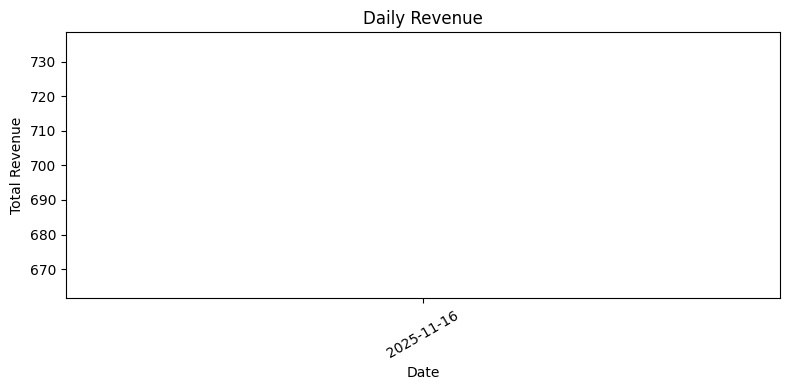

Memory Bank recent notes:

[{'note': 'placed order 580dc027-2956-4e0f-a878-8d64a559cc08 tot=410.0',
  'ts': '2025-11-16T18:35:08.942015'},
 {'note': 'placed order 45addfa0-83c7-40a7-ac99-989277451751 tot=160.0',
  'ts': '2025-11-16T18:35:08.926364'},
 {'note': 'placed order 0918b5a4-acd0-4d67-8272-6cd389f68013 tot=130.0',
  'ts': '2025-11-16T18:35:08.905002'}]


In [6]:
# Generate reports and a plot (matplotlib; no specific colors)
report = await coord.generate_report(sess_id)
rprint("[bold magenta]Top items (aggregate qty):[/bold magenta]")
pprint(report)

# Daily summary
ra = await coord.report_agent.handle(sess_id, {"action":"daily_summary"})
rprint("[bold magenta]Daily summary:[/bold magenta]")
pprint(ra)

# Plot total sales per day
df_sales = pd.read_csv("data/sales.csv")
df_sales['date'] = pd.to_datetime(df_sales['timestamp']).dt.date
daily = df_sales.groupby('date')['total'].sum().reset_index()
if not daily.empty:
    plt.figure(figsize=(8,4))
    plt.plot(daily['date'].astype(str), daily['total'])
    plt.title("Daily Revenue")
    plt.xlabel("Date")
    plt.ylabel("Total Revenue")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()
else:
    rprint("[yellow]No sales to plot yet[/yellow]")

# Memory check
rprint("[bold blue]Memory Bank recent notes:[/bold blue]")
pprint(memory.recall("demo"))


**Evaluation & memory output**

In [9]:
# CEvaluation + Hooks for LLM integration (commented)
# Simple local "unit test" scoring: does agent update inventory and persist sales?
def evaluate_demo():
    df_inv = pd.read_csv("data/inventory.csv")
    df_sales = pd.read_csv("data/sales.csv")
    score = 0
    # implemented features check
    if len(df_sales) >= 3: score += 20
    if "Rice (kg)" in df_inv['name'].values: score += 10
    # memory presence
    # ... add more checks per Kaggle rubric
    return {"score": score, "details": {"sales_rows": len(df_sales), "inv_rows": len(df_inv)}}

print("Evaluation:", evaluate_demo())

# === OPTIONAL: Where to integrate a real LLM/ADK/Gemini ===
# Replace BillingAgent.handle / ReportAgent.handle behavior with calls to an LLM.
# Example (pseudocode):
#   from google.genai import Client
#   client = Client(api_key="YOUR_KEY")
#   response = client.generate(prompt=..., model="gemini-1.5")

Evaluation: {'score': 10, 'details': {'sales_rows': 0, 'inv_rows': 6}}
